# Population Study for Income Classification
In this study we create classification model to determine whether a person makes over 50K a year based on some demographic, professional, financial and family data.

In [1]:
import pandas as pd

salary = pd.read_csv("au_train.csv")
salary.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,class
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [2]:
salary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
age               32561 non-null int64
workclass         32561 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education-num     32561 non-null int64
marital-status    32561 non-null object
occupation        32561 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital-gain      32561 non-null int64
capital-loss      32561 non-null int64
hours-per-week    32561 non-null int64
native-country    32561 non-null object
class             32561 non-null object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


The training data contains 32561 instances including 6 numerical and 9 categorical attributes including classification. There is no missing data.

In [24]:
salary["workclass"].value_counts() #9
#salary["education"].value_counts() #16
salary["marital-status"].value_counts() #7
salary["occupation"].value_counts() #15
salary["relationship"].value_counts() #6
salary["race"].value_counts() #5
salary["sex"].value_counts() #2
print("native-country:", len(salary["native-country"].value_counts())) #42
print(salary["class"].value_counts()) #2
salary.groupby(["education","education-num"]).size().reset_index().sort_values(by=["education-num"])

native-country: 42
 <=50K    24720
 >50K      7841
Name: class, dtype: int64


,education,education-num,0
13,Preschool,1,51
3,1st-4th,2,168
4,5th-6th,3,333
5,7th-8th,4,646
6,9th,5,514
0,10th,6,933
1,11th,7,1175
2,12th,8,433
11,HS-grad,9,10501
15,Some-college,10,7291


Reviewing the categorical data, there is no missing values but many attributes have '?' category where likely the data was missing, for this study we leave it as is since the count is not high. The 'education' category was excluded from study because it correlates exactly with 'education-num' and 'education-num' also provides ordering. We have a skewed classification data set where '<=50K' class has 24,720 instances and '>50K' class has 7,841 (so that base-line is ~75.92%).

In [4]:
salary.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


Data generally looks as expected, average 'age' of population around 37 years, 'education' - Some-College, most of the people do not have either 'capital-gain' or 'capital-loss' and the average 'hours-per-week' is 40. Looks like the 'age' was capped at 90, though it should not significantly impact the study, 'capital-gain' might have been capped too.

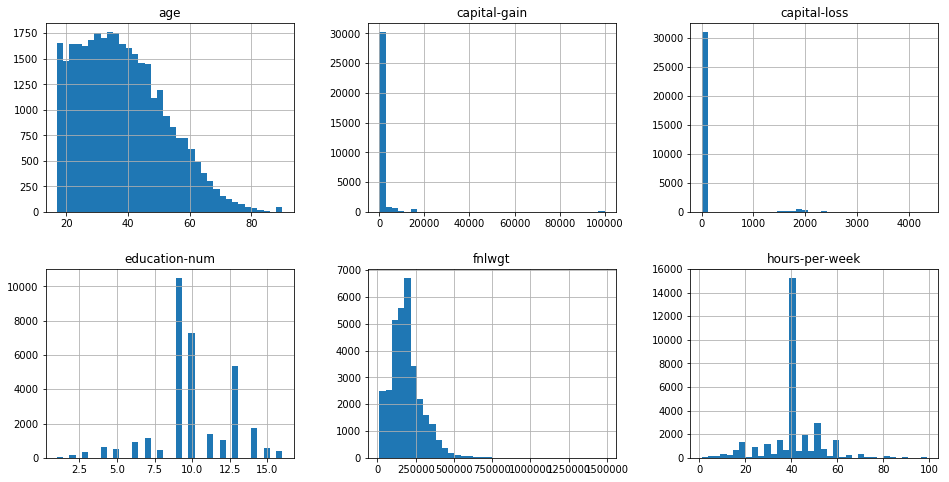

In [16]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
_ = salary.hist(layout=(2,3), figsize=(16,8), bins=36)

The distribution of 'age' and 'fnlwgt' have right tail, the logarithm transformation makes the distribution more normal but for the selected classification algorithm (Ada Boost based on the Decision Trees) it does not make difference.

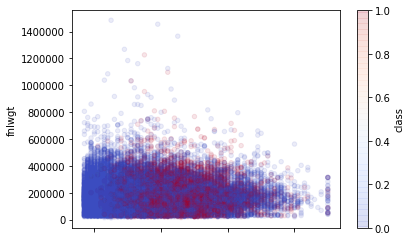

In [17]:
salary_num = salary[["age","fnlwgt","education-num","capital-gain","capital-loss","hours-per-week","class"]].copy()
salary_num["class"] = salary_num["class"].astype("category").cat.codes
_ = salary_num.plot(kind="scatter", x="age", y="fnlwgt", c="class", cmap=plt.get_cmap("coolwarm"), alpha=0.1)

The scatter plot of the 'age' vs 'fnlwgt' with 'class' = '>50K' highlighted in red shows that the classes are mixed pretty well for these attributes. Also we can see as expected that people with higher salaries are in mid to late of their career and we can see the age cap at 90.

In [18]:
salary_num.corr()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week,class
age,1.000000,-0.076646,0.036527,0.077674,0.057775,0.068756,0.234037
fnlwgt,-0.076646,1.000000,-0.043195,0.000432,-0.010252,-0.018768,-0.009463
education-num,0.036527,-0.043195,1.000000,0.122630,0.079923,0.148123,0.335154
capital-gain,0.077674,0.000432,0.122630,1.000000,-0.031615,0.078409,0.223329
capital-loss,0.057775,-0.010252,0.079923,-0.031615,1.000000,0.054256,0.150526
hours-per-week,0.068756,-0.018768,0.148123,0.078409,0.054256,1.000000,0.229689
class,0.234037,-0.009463,0.335154,0.223329,0.150526,0.229689,1.000000


The correlation table displays not significant correlation between the numerical attributes. The correlation for the classification somewhat higher with 'age', 'education-num' and 'hours-per-week' expected to be most significant for the classification.

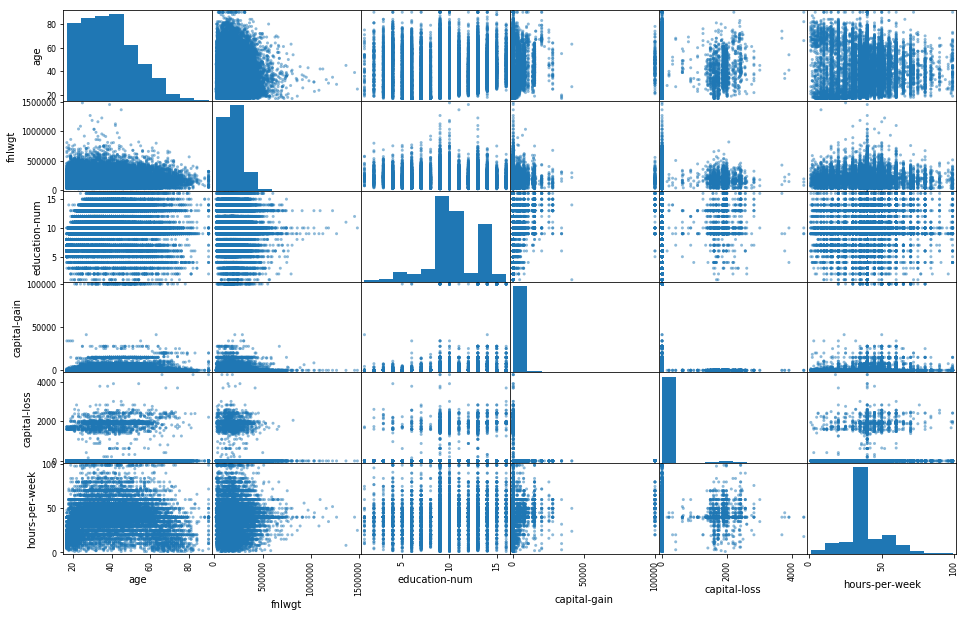

In [19]:
_ = pd.plotting.scatter_matrix(salary, figsize=(16, 10))

Below is the helper functions and pipeline to scale data and transform to one-hot encoding for the categorical attributes

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, LabelBinarizer

y = salary["class"] == " >50K"

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names

    def fit(self, x, y=None):
        return self

    def transform(self, x):
        return x[self.attribute_names].values

    
class CustomIndicator(BaseEstimator, TransformerMixin):
    def __init__(self, data):
        self.data = data

    def fit(self, x, y=None):
        return self

    def transform(self, x):
        return LabelBinarizer().fit(self.data).transform(x)


numerics = ["age","fnlwgt","education-num","capital-gain","capital-loss","hours-per-week"]
numeric_pl = Pipeline([
    ('selector', DataFrameSelector(numerics)),
    ('std_scale', StandardScaler()),
])
workclass_pl = Pipeline([
    ('selector', DataFrameSelector(["workclass"])),
    ('label_indicator', CustomIndicator(salary["workclass"])),
])
marital_pl = Pipeline([
    ('selector', DataFrameSelector(["marital-status"])),
    ('label_indicator', CustomIndicator(salary["marital-status"])),
])
occupation_pl = Pipeline([
    ('selector', DataFrameSelector(["occupation"])),
    ('label_indicator', CustomIndicator(salary["occupation"])),
])
relationship_pl = Pipeline([
    ('selector', DataFrameSelector(["relationship"])),
    ('label_indicator', CustomIndicator(salary["relationship"])),
])
race_pl = Pipeline([
    ('selector', DataFrameSelector(["race"])),
    ('label_indicator', CustomIndicator(salary["race"])),
])
sex_pl = Pipeline([
    ('selector', DataFrameSelector(["sex"])),
    ('label_indicator', CustomIndicator(salary["sex"])),
])
country_pl = Pipeline([
    ('selector', DataFrameSelector(["native-country"])),
    ('label_indicator', CustomIndicator(salary["native-country"])),
])
full_pipeline = FeatureUnion(transformer_list=[
    ("numeric_pl", numeric_pl),
    ("workclass_pl", workclass_pl),
    ("marital_pl", marital_pl),
    ("occupation_pl", occupation_pl),
    ("relationship_pl", relationship_pl),
    ("race_pl", race_pl),
    ("sex_pl", sex_pl),
    ("country_pl", country_pl),
])
x = full_pipeline.fit_transform(salary)
attributes = numerics.copy()
for attr in ["workclass","marital-status","occupation","relationship","race","sex","native-country"]:
    attributes += [attr + e for e in salary[attr].unique().tolist()]

d:\project\aunalytics\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
d:\project\aunalytics\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

param_grid = [ #n_estimators=159,max_depth=19,max_leaf_nodes=92
    {'n_estimators': range(159, 160), 'max_depth': range(19, 20), 'max_leaf_nodes': range(92, 93)},
]
grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(x, y)
print("Best Score:", grid_search.best_score_) #0.8575289456712017
print("Best Grid Params:", grid_search.best_params_)
print("Best Estimator:", grid_search.best_estimator_)
print("Random Forest Feature Importance:")
sorted(zip(grid_search.best_estimator_.feature_importances_, attributes), reverse=True)[:20]

Best Score: 0.8576517920211296
Best Grid Params: {'max_depth': 19, 'max_leaf_nodes': 92, 'n_estimators': 159}
Best Estimator: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=19, max_features='auto', max_leaf_nodes=92,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=159, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Random Forest Feature Importance:


[(0.15900318731255056, 'capital-gain'),
 (0.14092238836620222, 'education-num'),
 (0.13999574496642464, 'marital-status Divorced'),
 (0.11104068720765503, 'relationship Not-in-family'),
 (0.059861083488803216, 'marital-status Separated'),
 (0.05982335577577577, 'age'),
 (0.04138462168716185, 'hours-per-week'),
 (0.04018537011300956, 'capital-loss'),
 (0.03679174172859534, 'occupation Other-service'),
 (0.02914457206498913, 'occupation Tech-support'),
 (0.02412302962859571, 'relationship Husband'),
 (0.02025497875329294, 'relationship Own-child'),
 (0.01819703528119486, 'sex Male'),
 (0.016429916844205677, 'relationship Other-relative'),
 (0.012099334363566746, 'marital-status Never-married'),
 (0.010983333597703818, 'occupation Farming-fishing'),
 (0.009871863061857706, 'relationship Unmarried'),
 (0.006390380269263161, 'fnlwgt'),
 (0.006094324905078468, 'workclass ?'),
 (0.005276244487496808, 'occupation Sales')]

The RandomForest classifier is one of the most popular classification algorithms, it provides a base-line of the metrics and in addition it has the feature significance metrics that can be used for feature selection (I was using that for kNN algorithm but it did not have good performance and was not included). We can see from the data that 'capital-gain', 'education-num', 'age', 'hours-per-week' and 'capital-loss' numerical attributes were rated high, as well as 'marital-status', 'relationship' and 'occupation' categorical attributes.

In [22]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

param_grid = [ #n_estimators=190, learning_rate=1.4
    {"n_estimators": range(190, 191), "learning_rate": [1.4]},
]
grid_search = GridSearchCV(AdaBoostClassifier(), param_grid, cv=5)
grid_search.fit(x, y)
print("Best Score:", grid_search.best_score_) #0.8691072141518995
print("Best Grid Params:", grid_search.best_params_)
print("Best Estimator:", grid_search.best_estimator_)

Best Score: 0.8691072141518995
Best Grid Params: {'learning_rate': 1.4, 'n_estimators': 190}
Best Estimator: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.4, n_estimators=190, random_state=None)


After experimenting with several different algorithms, I have selected the AdaBoost classifier that provides the highest accuracy of 86.91%. Using the grid search with 5-fold cross-validation, the optimal hyper-parameters of number of estimators = 190 and learning rate of 1.4 were selected.

Accuracy: 0.8691072141518995
Confusion Matrix:
 [[23232  1488]
 [ 2774  5067]]
Precision: 0.7729977116704806
Recall: 0.6462185945670195
F1 Score: 0.7039455404278966
AUC Score: 0.9243075616139378


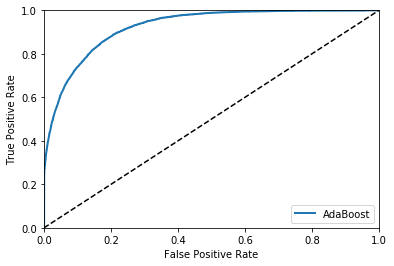

In [33]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

y_predict = cross_val_predict(grid_search.best_estimator_, x, y, cv=5)
print("Accuracy:", accuracy_score(y, y_predict))
print("Confusion Matrix:\n", confusion_matrix(y, y_predict))
print('Precision:', precision_score(y, y_predict))
print('Recall:', recall_score(y, y_predict))
print("F1 Score:", f1_score(y, y_predict))

y_predict = cross_val_predict(grid_search.best_estimator_, x, y, cv=5, method="decision_function")
fpr, tpr, thresholds_sgd = roc_curve(y, y_predict)
plt.plot(fpr, tpr, linewidth=2, label="AdaBoost")
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
print("AUC Score:", roc_auc_score(y, y_predict))

The AdaBoost algorithm achieves 86.91% accuracy which is a moderate improvement over the the 75.92% base-line. In the skewed classification problem the accuracy is not prefered measure of quality. The confusion matrix shows detail of the errors with 23,232 true negatives and 5,067 true positives; we also have 1,488 false positives and 2,774 false negatives. So the classifier correctly identify 64.62% of the '>50K' class and 77.3% of classified '>50k' instances are correct. The combination of precision and recall is F1 score = 70.4%. The selection of performance metrics depends on the details of study but the precision/recall trade-off allows to adjust threshold to reduce the necessary type of error. The ROC curve shows that AdaBoost classifier has better score than random classifier (dotted line), the AUC score = 0.9243.

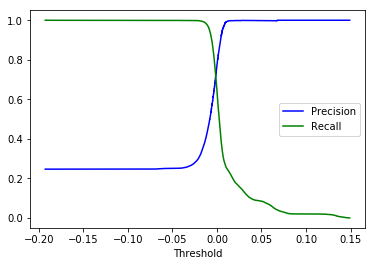

In [34]:
precisions, recalls, thresholds = precision_recall_curve(y, y_predict)
plt.plot(thresholds, precisions[:-1], "b", label="Precision")
plt.plot(thresholds, recalls[:-1], "g", label="Recall")
plt.xlabel("Threshold")
_ = plt.legend(loc="center right")

In [37]:
salary_test = pd.read_csv("au_test.csv")
salary_test.head()
salary_test.describe()
print(salary_test["class"].value_counts())

x_test = full_pipeline.fit_transform(salary_test)
y_test = salary_test["class"] == " >50K"

print("Accuracy:", accuracy_score(y_test, grid_search.best_estimator_.predict(x_test)))

 <=50K.    12435
 >50K.      3846
Name: class, dtype: int64


d:\project\aunalytics\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
d:\project\aunalytics\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


Accuracy: 0.8078127879122904


The test set accuracy is 80.78% which is lower than classifier cross-validation accuracy of 86.91%, the data in the test set has similar distribution to the training data so some further analysis of the training set errors should be done to improve classification.